In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [2]:
df = pd.read_pickle("../data/df.pickle")

In [3]:
"""Note
データセットの分割
lockdown(2020/4/1~2020/5/31)
2020/6/1~2020/10/31
2020/11/1~2020/11/30
2020/12/1~2020/12/31
2021/1/1~2021/12/31
2022/1/1~2022/12/31
2023/1/1~2023/9/30
"""

# データセットの分割
df_lockdown = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] <= "2020-05-31")]
df_202006_202010 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] <= "2020-10-31")]
df_202011 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] <= "2020-11-30")]
df_202012 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] <= "2020-12-31")]
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2021-12-31")]
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2022-12-31")]
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] <= "2023-09-30")]
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] <= "2020-12-31")]

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [5]:
# activity distribution
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [6]:
label_list = ["Lockdown", "2020/6/1~2020/10/31", "2020/11/1~2020/11/30", "2020/12/1~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

In [7]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp


In [8]:
node_lockdown, edge_lockdown, timestamp_lockdown = getNetworkAnalysis(df_lockdown)
node_202006_202010, edge_202006_202010, timestamp_202006_202010 = getNetworkAnalysis(df_202006_202010)
node_202011, edge_202011, timestamp_202011 = getNetworkAnalysis(df_202011)
node_202012, edge_202012, timestamp_202012 = getNetworkAnalysis(df_202012)
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023 = getNetworkAnalysis(df_2023)

In [9]:
Np = 1416

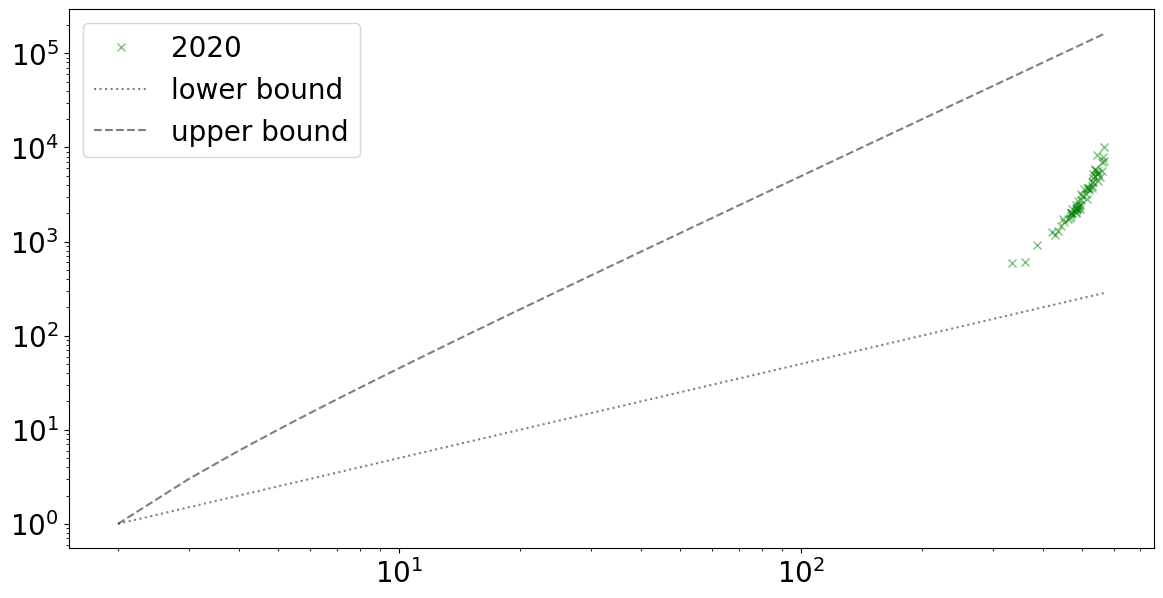

In [13]:
plt.figure(figsize=(14,7))

N = node_lockdown
M = edge_lockdown # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="2020")

"""
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]
"""

# plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20}) 
plt.show()

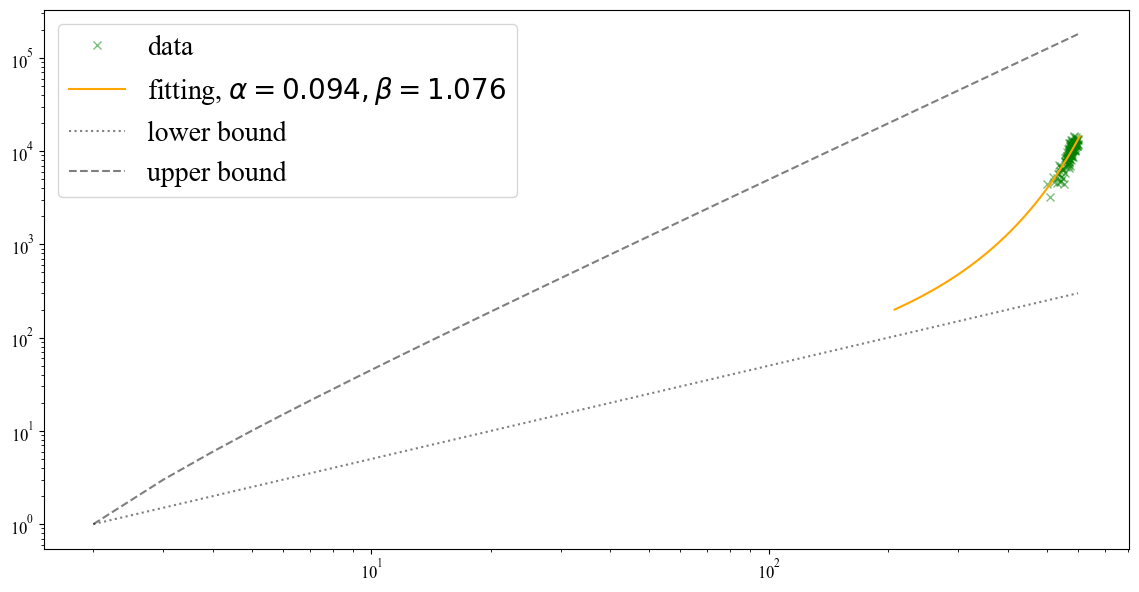

In [50]:
plt.figure(figsize=(14,7))

N = node_202006_202010
M = edge_202006_202010 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20})
plt.show()

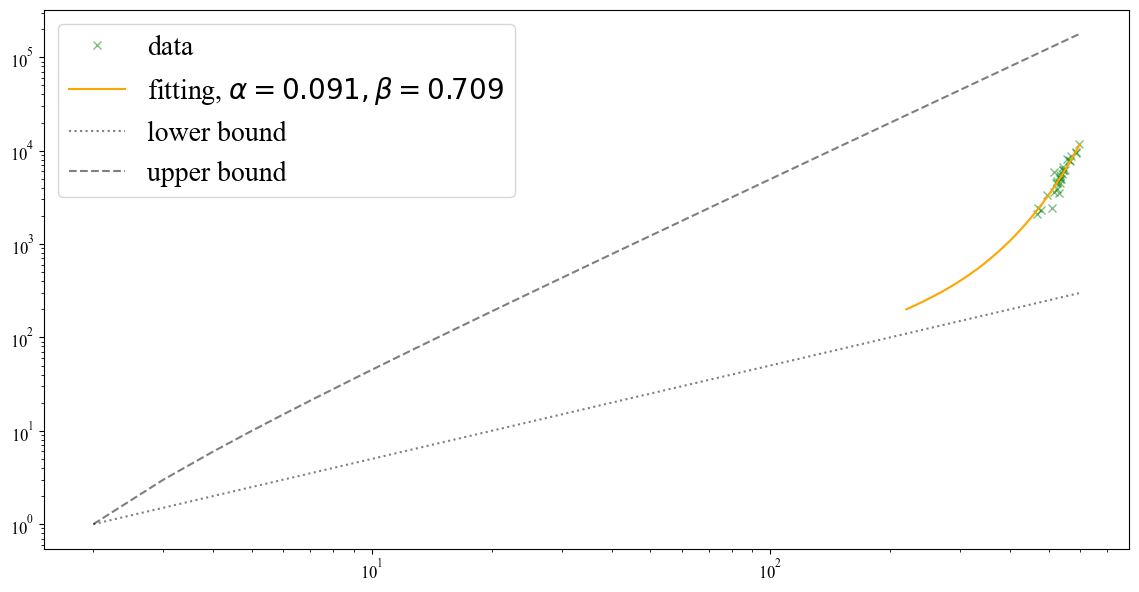

In [51]:
plt.figure(figsize=(14,7))

N = node_202011
M = edge_202011 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20})
plt.show()

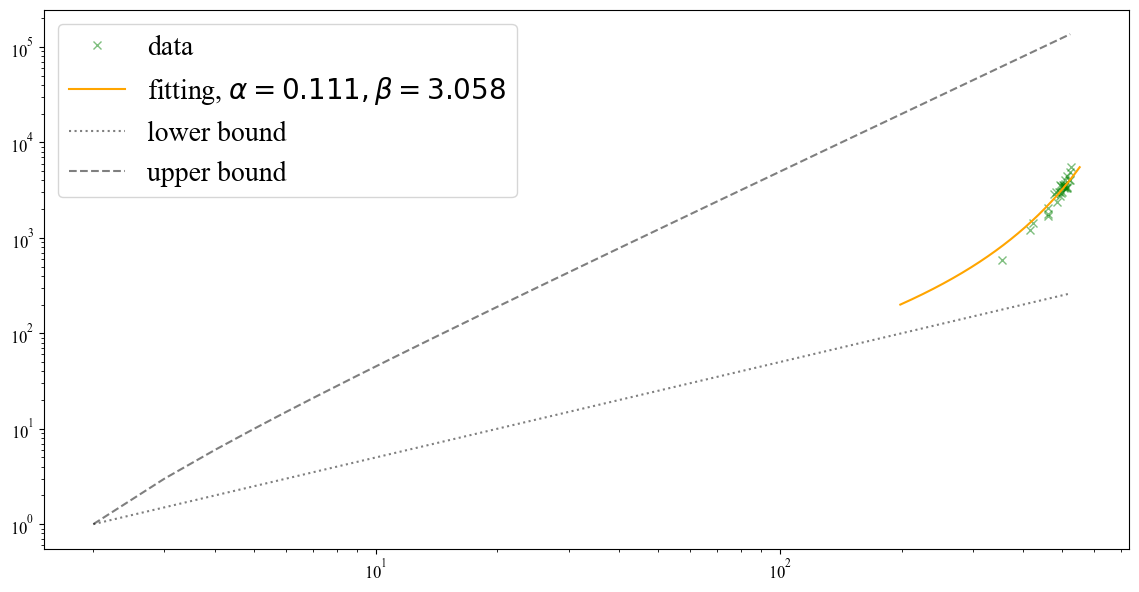

In [52]:
plt.figure(figsize=(14,7))

N = node_202012
M = edge_202012 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20})
plt.show()

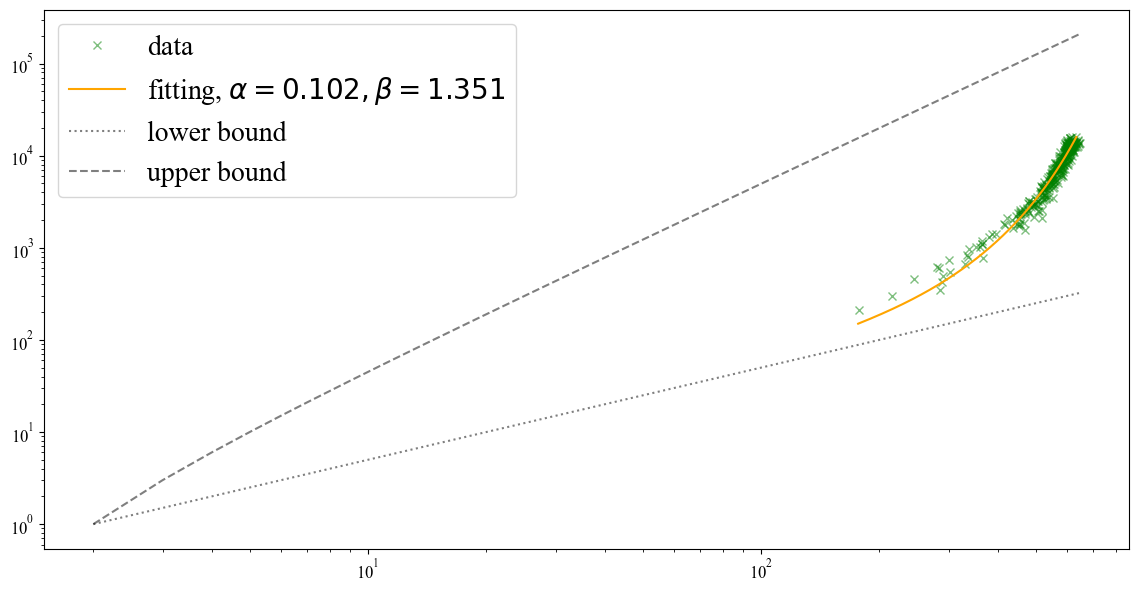

In [53]:
plt.figure(figsize=(14,7))

N = node_2021
M = edge_2021 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(150, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20})
plt.show()

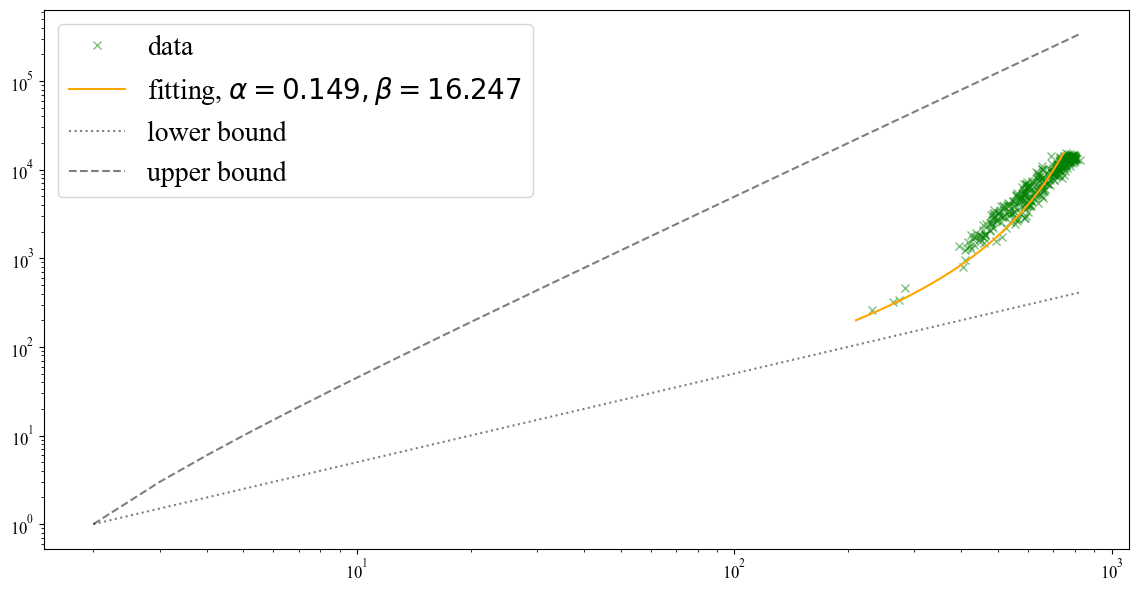

In [54]:
plt.figure(figsize=(14,7))

N = node_2022
M = edge_2022 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20})
plt.show()

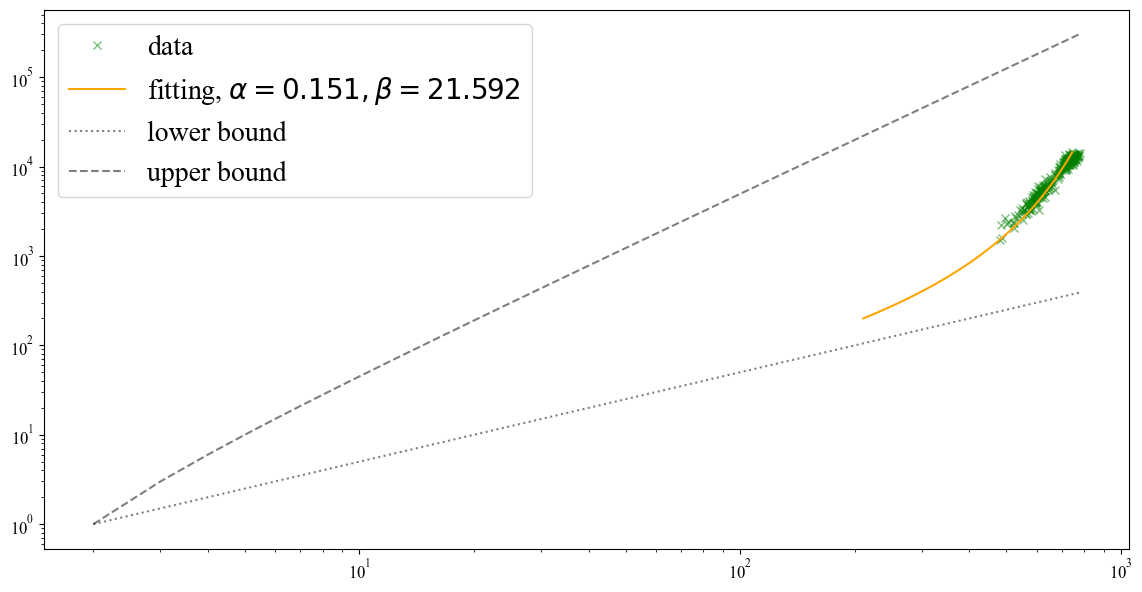

In [55]:
plt.figure(figsize=(14,7))

N = node_2023
M = edge_2023 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
# plt.title("Lockdown")
# plt.xlabel(r"$N$")
# plt.ylabel(r"$M$")
plt.legend(prop={'size': 20})
plt.show()

In [57]:
alpha_list = [0.088, 0.094, 0.091, 0.111, 0.102, 0.149, 0.151]
beta_list = [0.541, 1.076, 0.709, 3.058, 1.351, 16.247, 21.592]

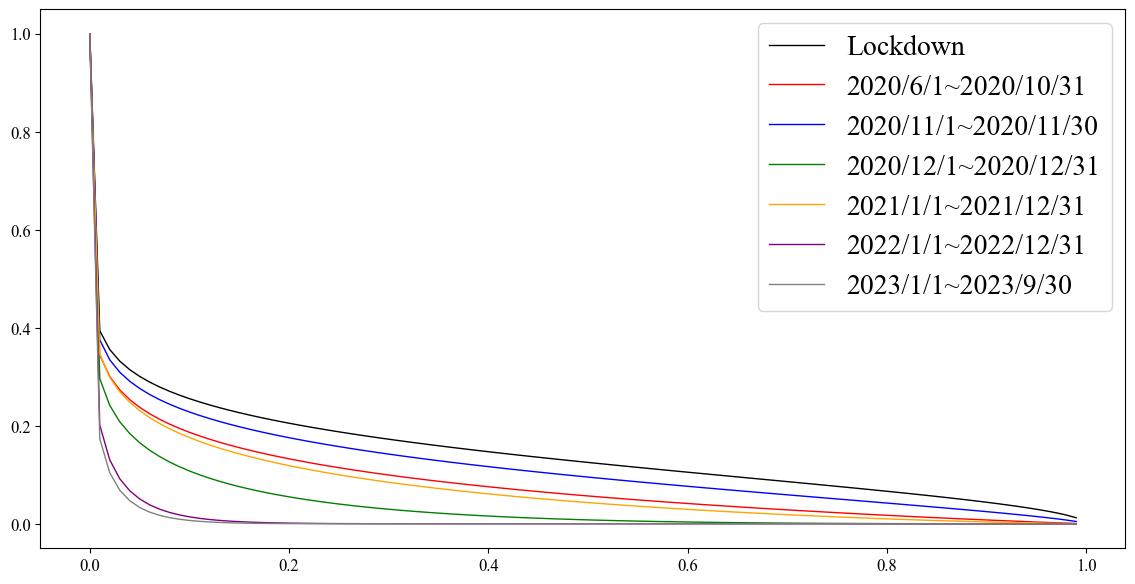

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

fig = plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

# Create a range of values from 0 to 1
x = np.linspace(0, 1, 1000)

color_list = ["black", "red", "blue", "green", "orange", "purple", "gray"]

# alpha, betaのリストに対してCCDFを計算
for i in range(len(alpha_list)):
    ccdf = 1 - special.betainc(alpha_list[i], beta_list[i], a)
    plt.plot(a, ccdf, label=label_list[i], linewidth=1, color=color_list[i])


# plt.xlabel("Activity")
# plt.ylabel("CCDF")
# plt.title("Complementary Cumulative Distribution Function")
plt.legend(prop={'size': 20})
plt.show()

In [62]:
kappa_list_lockdown = []
for i in range(len(edge_lockdown)):
    alpha = alpha_list[0]
    beta = beta_list[0]
    kappa_list_lockdown.append(kappa(edge_lockdown[i], Np))

kappa_list_202006_202010 = []
for i in range(len(edge_202006_202010)):
    alpha = alpha_list[1]
    beta = beta_list[1]
    kappa_list_202006_202010.append(kappa(edge_202006_202010[i], Np))

kappa_list_202011 = []
for i in range(len(edge_202011)):
    alpha = alpha_list[2]
    beta = beta_list[2]
    kappa_list_202011.append(kappa(edge_202011[i], Np))

kappa_list_202012 = []
for i in range(len(edge_202012)):
    alpha = alpha_list[3]
    beta = beta_list[3]
    kappa_list_202012.append(kappa(edge_202012[i], Np))

kappa_list_2021 = []
for i in range(len(edge_2021)):
    alpha = alpha_list[4]
    beta = beta_list[4]
    kappa_list_2021.append(kappa(edge_2021[i], Np))

kappa_list_2022 = []
for i in range(len(edge_2022)):
    alpha = alpha_list[5]
    beta = beta_list[5]
    kappa_list_2022.append(kappa(edge_2022[i], Np))

kappa_list_2023 = []
for i in range(len(edge_2023)):
    alpha = alpha_list[6]
    beta = beta_list[6]
    kappa_list_2023.append(kappa(edge_2023[i], Np))

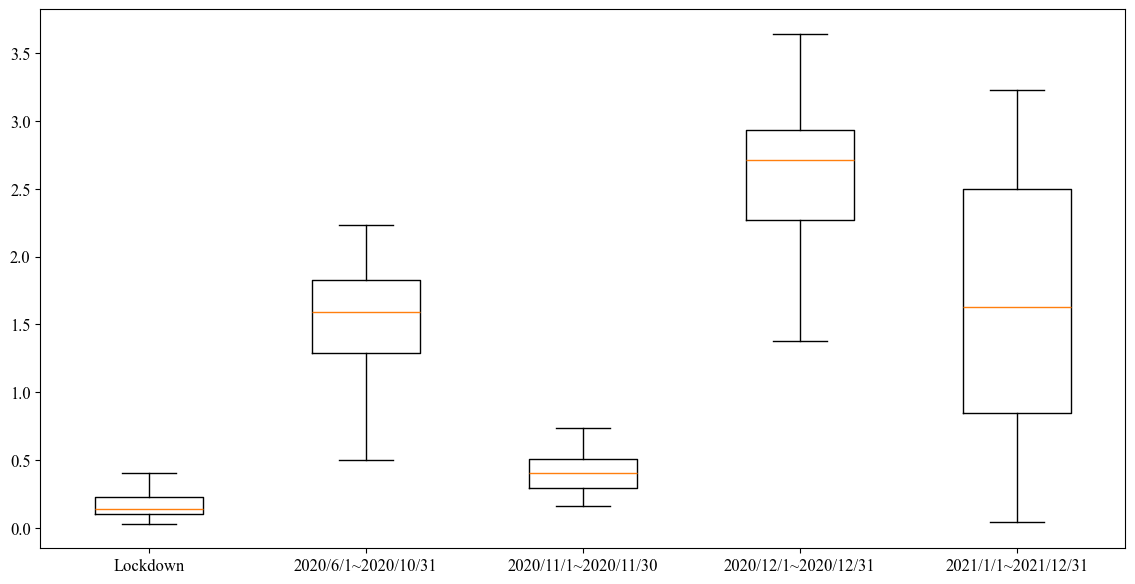

In [66]:
# box plot
plt.figure(figsize=(14,7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

data = [kappa_list_lockdown, kappa_list_202006_202010, kappa_list_202011, kappa_list_202012, kappa_list_2021]
plt.boxplot(data, labels=label_list[:5], showfliers=False)
# plt.xlabel("Period")
# plt.ylabel(r"$\kappa$")
plt.show()

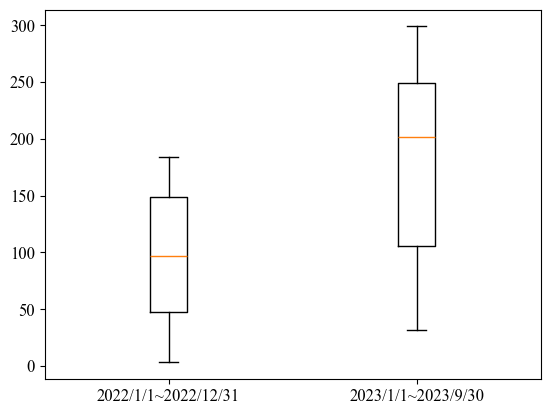

In [67]:
data = [kappa_list_2022, kappa_list_2023]
plt.boxplot(data, labels=label_list[5:], showfliers=False)
# plt.xlabel("Period")
# plt.ylabel(r"$\kappa$")
plt.show()

In [34]:
# 2020年のkappaを結合する
kappa_list_2020 = kappa_list_lockdown + kappa_list_202006_202010 + kappa_list_202011 + kappa_list_202012

In [39]:
len(kappa_list_2020)

269

In [40]:
# kappa_list_2021を269日分にする
kappa_list_2021 = kappa_list_2021[:269]

# kappa_list_2022を269日分にする
kappa_list_2022 = kappa_list_2022[:269]

# kappa_list_2023を269日分にする
kappa_list_2023 = kappa_list_2023[:269]

In [43]:
# kappa_listを正規化する
kappa_list_2020 = kappa_list_2020 / np.max(kappa_list_2020)
kappa_list_2021 = kappa_list_2021 / np.max(kappa_list_2021)
kappa_list_2022 = kappa_list_2022 / np.max(kappa_list_2022)
kappa_list_2023 = kappa_list_2023 / np.max(kappa_list_2023)

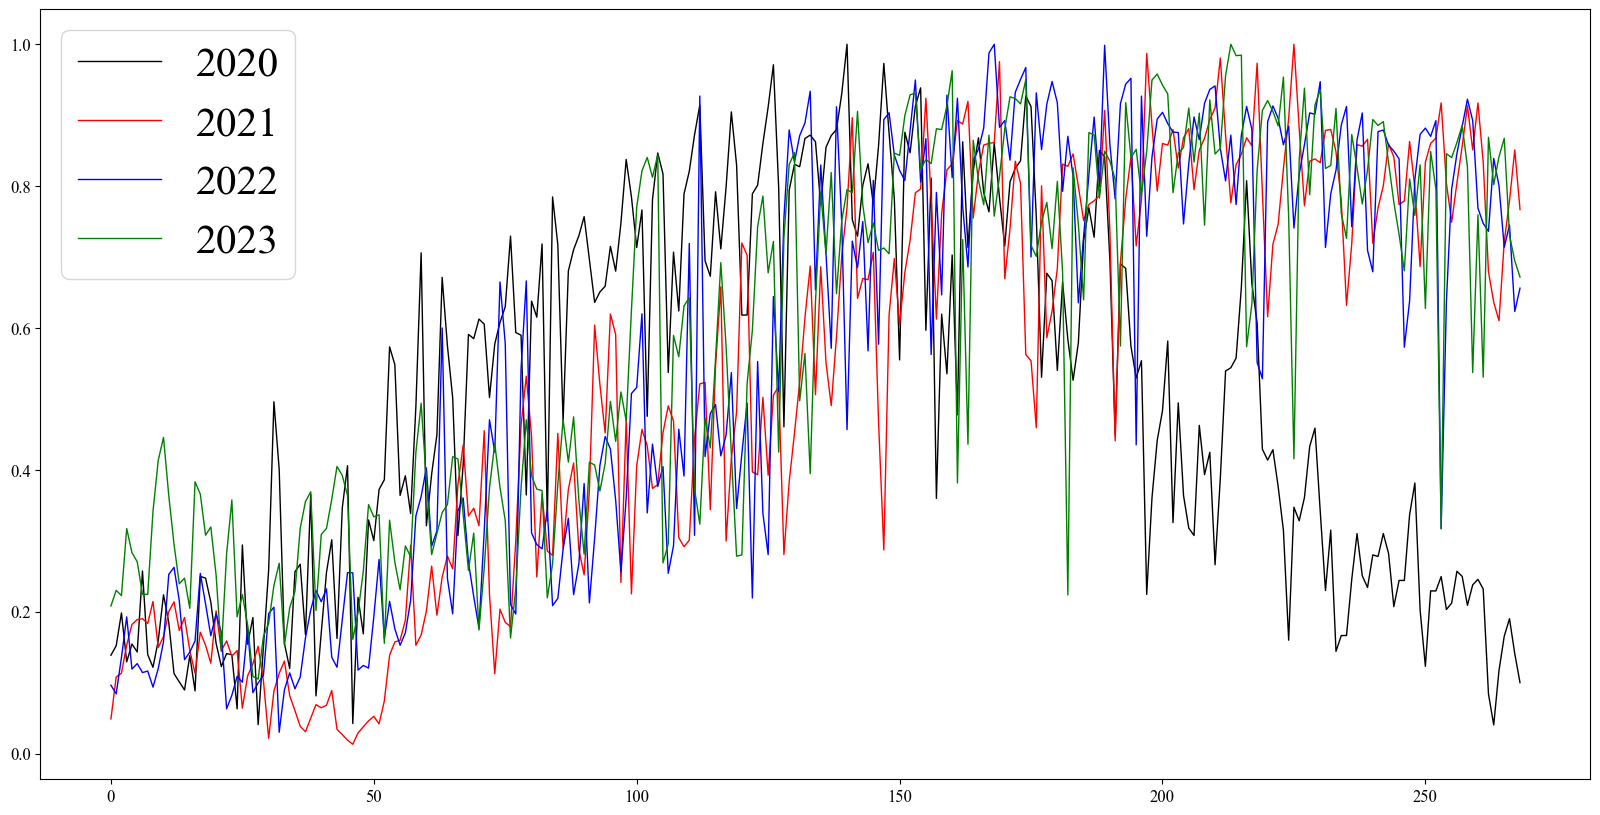

In [44]:
kappa_list = [kappa_list_lockdown, kappa_list_202006_202010, kappa_list_202011, kappa_list_202012, kappa_list_2021, kappa_list_2022, kappa_list_2023]
timestamp_list = [timestamp_lockdown, timestamp_202006_202010, timestamp_202011, timestamp_202012, timestamp_2021, timestamp_2022, timestamp_2023]

plt.figure(figsize=(20, 10))

plt.plot(kappa_list_2020, label="2020", linewidth=1, color="black")
plt.plot(kappa_list_2021, label="2021", linewidth=1, color="red")
plt.plot(kappa_list_2022, label="2022", linewidth=1, color="blue")
plt.plot(kappa_list_2023, label="2023", linewidth=1, color="green")

# plt.xlabel("Time")
# plt.ylabel("Kappa")

plt.legend(prop={'size': 30})
plt.show()